In [ ]:
# export SPARK_HOME=r"D:\Programs\spark-3.4.4-bin-hadoop3\spark-3.4.4-bin-hadoop3"

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
import sys
import os

os.environ['HADOOP_HOME'] = r"D:\Programs\hadoop\hadoop-3.4.4"
sys.path.append("D:\Programs\hadoop\hadoop-3.4.4\bin")
jdbc_path = r"C:\Users\atul1\Downloads\snowflake-jdbc-3.13.28.jar"
spark_sf_connector_path = r"C:\Users\atul1\Downloads\spark-snowflake_2.12-2.14.0-spark_3.2.jar"

In [3]:
spark = SparkSession.builder \
                .appName("SnowflakeIntegration") \
                .config("spark.jars", f"{jdbc_path},{spark_sf_connector_path}") \
                .config("spark.executor.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .config("spark.driver.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .getOrCreate()

In [4]:
spark

In [5]:
spark.sparkContext.stop()

In [6]:
import pyspark
print(pyspark.__version__)

3.4.4


## Import for the files

In [7]:
import snowflake.connector as sfconnector
from snowflake.connector import ProgrammingError
import pandas as pd
from pyspark.sql import SparkSession

class SFConnector:
    def __init__(self, account, user, password, warehouse, database, schema):
        """
        Initialize the SFConnector with required Snowflake connection details.
        """
        self.account = account
        self.user = user
        self.password = password
        self.warehouse = warehouse
        self.database = database
        self.schema = schema
        self.conn = None
        self.cursor = None
        self.spark_session = None
        self.connect()

    def connect(self):
        """
        Establish a connection to the Snowflake database.
        """
        try:
            self.conn = sfconnector.connect(
                account=self.account,
                user=self.user,
                password=self.password,
                warehouse=self.warehouse,
                database=self.database,
                schema=self.schema
            )
            self.cursor = self.conn.cursor()
            print("Connected to Snowflake successfully.")
        except ProgrammingError as e:
            print(f"Error connecting to Snowflake: {e}")
            raise

    def close_connection(self):
        """
        Close the connection and cursor if open.
        """
        if self.cursor:
            self.cursor.close()
        if self.conn:
            self.conn.close()
        print("Connection to Snowflake closed.")

    def execute_query(self, qry, fetch_one=False, fetch_all=False):
        """
        Execute a query and fetch results.
        :param qry: The query to execute.
        :param fetch_one: If True, fetches one result.
        :param fetch_all: If True, fetches all results.
        :return: Query results or None if no fetch is requested.
        """
        if not self.conn:
            self.connect()
        
        try:
            self.cursor.execute(qry)
            if fetch_one:
                return self.cursor.fetchone()
            if fetch_all:
                return self.cursor.fetchall()
            # Return None if no fetch is specified
        except ProgrammingError as e:
            print(f"Error executing query: {e}")
            raise

    def fetch_as_pandas(self, qry):
        """
        Fetch query results as a Pandas DataFrame.
        :param qry: The query to execute.
        :return: Pandas DataFrame with query results.
        """
        if not self.conn:
            self.connect()
        try:
            df = pd.read_sql(qry, self.conn)
            return df
        except Exception as e:
            print(f"Error fetching data as Pandas DataFrame: {e}")
            raise

    def fetch_as_spark(self, qry):
        """
        Fetch query results as a Spark DataFrame using the Snowflake Spark Connector.
        :param qry: The query to execute.
        :return: Spark DataFrame with query results.
        """
        if not self.spark_session:
            self.spark_session = SparkSession.builder \
                .appName("SnowflakeIntegration") \
                .config("spark.jars", f"{jdbc_path},{spark_sf_connector_path}") \
                .config("spark.executor.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .config("spark.driver.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .getOrCreate()
        
        print("Created Spark Session Successfully")

        snowflake_options = {
            "sfURL": f"{self.account}.snowflakecomputing.com",
            "sfDatabase": self.database,
            "sfSchema": self.schema,
            "sfWarehouse": self.warehouse,
            "sfUser": self.user,
            "sfPassword": self.password,
        }

        try:
            df = self.spark_session.read \
                .format("snowflake") \
                .options(**snowflake_options) \
                .option("query", qry) \
                .load()
            print("Fetched the data successfully")
            return df
        except Exception as e:
            print(f"Error fetching data as Spark DataFrame: {e}")
            raise
    
    def create_table_from_spark(self, query, table_name, mode="overwrite"):
        """
        Creates a new table in Snowflake using a query to fetch data into a Spark DataFrame,
        and then writes it to a Snowflake table.
        :param query: The query to execute and fetch data.
        :param table_name: The name of the Snowflake table to create.
        :param mode: The mode to use, either 'overwrite' or 'append'.
        :return: None
        """
        if not self.spark_session:
            self.spark_session = SparkSession.builder \
                .appName("SnowflakeIntegration") \
                .config("spark.jars", f"{jdbc_path},{spark_sf_connector_path}") \
                .config("spark.executor.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .config("spark.driver.extraClassPath", f"{jdbc_path}:{spark_sf_connector_path}") \
                .getOrCreate()

        # Define Snowflake options
        snowflake_options = {
            "sfURL": f"{self.account}.snowflakecomputing.com",
            "sfDatabase": self.database,
            "sfSchema": self.schema,
            "sfWarehouse": self.warehouse,
            "sfUser": self.user,
            "sfPassword": self.password,
        }

        try:
            # Fetch the data into a Spark DataFrame using the provided query
            df_spark = self.fetch_as_spark(query)
            df_spark.show(3)

            # Write the Spark DataFrame to Snowflake
            df_spark.write \
                .format("snowflake") \
                .options(**snowflake_options) \
                .option("dbtable", table_name) \
                .mode(mode) \
                .save()

            print(f"Table {table_name} created successfully in Snowflake.")
        except Exception as e:
            print(f"Error creating table in Snowflake: {e}")
            raise


In [ ]:
sfconn =SFConnector(
    account="HDQWYFS-JW43057",
    user='',
    password='',
    warehouse='COMPUTE_WH',
    database='MEDICAL_CLAIMS_COST',
    schema='PATIENTS_CLAIMS_COST'
)

d:\Anaconda\envs\medicalclaims\lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\atul1\.snowflake\connections.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


Connected to Snowflake successfully.


In [9]:
conn = sfconn.get_connection()

AttributeError: 'SFConnector' object has no attribute 'get_connection'

In [ ]:
cursor = sfconn.get_cursor()

## Test Connection

In [36]:
resutls = sfconn.execute_query("SELECT COUNT(DESYNPUF_ID) FROM CLAIMS_DETAILS" ,fetch_one=True)

In [37]:
resutls

(1583322,)

## REAL WORK

### Get the data 

In [41]:
query = "SELECT * FROM CLMID_MCID_INFO"
CLM_MCID_SP_DF = sfconn.fetch_as_spark(query)

Created Spark Session Sucessfully
Fetched the data successfully


In [6]:
CLM_MCID_SP_DF.show(5)

+---------------+----------------+-----------+-----------+-----------+
|         CLM_ID|     DESYNPUF_ID|CLM_FROM_DT|CLM_THRU_DT|CLM_PMT_AMT|
+---------------+----------------+-----------+-----------+-----------+
|542192281063886|00013D2EFD8E45D1|   20080904|   20080904|      50.00|
|542272281166593|00016F745862898F|   20090602|   20090602|      30.00|
|542282281644416|00016F745862898F|   20090623|   20090623|      30.00|
|542642281250669|0001FDD721E223DC|   20091011|   20091011|      30.00|
|542242281386963|00024B3D2352D2D0|   20080712|   20080712|      30.00|
+---------------+----------------+-----------+-----------+-----------+
only showing top 5 rows



### Plot the time series to get the cutoff dates and graph

In [ ]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql import Window

class ClaimDataAnalyzer:
    def __init__(self, df, min_claims_threshold=100, lookahead_months=12):
        """
        Initialize the ClaimDataAnalyzer with the DataFrame and the minimum claims threshold.
        """
        self.df = df
        self.min_claims_threshold = min_claims_threshold
        self.training_months = None
        self.oot_months = None
        self.lookahead_months = lookahead_months

        # Initialize cutoff dates to None
        self.training_start_date = None
        self.training_end_date = None
        self.oot_start_date = None
        self.oot_end_date = None

    def preprocess_data(self):
        """
        Preprocess the data by converting date columns and extracting required features.
        """
        # Convert clm_from_dt and clm_thru_dt to date format
        self.df = self.df.withColumn("CLM_FROM_DT_DATE", 
                                     F.from_unixtime(F.unix_timestamp(F.col("CLM_FROM_DT").cast("string"), "yyyyMMdd")))
        self.df = self.df.withColumn("CLM_THRU_DT_DATE", 
                                     F.from_unixtime(F.unix_timestamp(F.col("CLM_THRU_DT").cast("string"), "yyyyMMdd")))

        # Extract year and month
        self.df = self.df.withColumn("YEAR", F.year(F.col("CLM_FROM_DT_DATE")))
        self.df = self.df.withColumn("MONTH", F.month(F.col("CLM_FROM_DT_DATE")))

    def select_cutoff(self):
        """
        Dynamically select the cutoff date based on the most recent months with enough claims.
        This method ensures that the next 12 months have a significant number of claims.
        """
        # Group by year and month, and count the number of claims
        claims_per_month = self.df.groupBy("YEAR", "MONTH") \
                                  .agg(F.count("CLM_ID").alias("NUM_CLAIMS")) \
                                  .filter(F.col("NUM_CLAIMS") >= self.min_claims_threshold)  # Filter based on threshold
        
        # Sort months by number of claims in descending order
        claims_per_month = claims_per_month.orderBy(F.col("NUM_CLAIMS").desc())

        # Initialize window for future claims calculations
        window_spec = Window.partitionBy("YEAR").orderBy("MONTH")

        # Add a column for the cumulative claims over the next 12 months
        claims_per_month = claims_per_month.withColumn(
            "FUTURE_CLAIMS",
            F.sum("NUM_CLAIMS").over(window_spec.rangeBetween(0, self.lookahead_months - 1))
        )

        # Get the month with the maximum future claims
        max_claims_row = claims_per_month.orderBy(F.col("FUTURE_CLAIMS").desc()).first()

        # Select the cutoff month (the one with the most future claims)
        cutoff_year, cutoff_month = max_claims_row['YEAR'], max_claims_row['MONTH']

        # Define the training and OOT months
        self.training_months = claims_per_month.filter(
            (F.col("YEAR") == cutoff_year) & (F.col("MONTH") <= cutoff_month)
        )

        # Get the OOT months as those after the last training month
        self.oot_months = claims_per_month.filter(
            (F.col("YEAR") > cutoff_year) | 
            ((F.col("YEAR") == cutoff_year) & (F.col("MONTH") > cutoff_month))
        )

        # Set training start and end date in 'YYYYMMDD' format
        self.training_start_date = pd.to_datetime(f"{cutoff_year}-{cutoff_month:02d}-01")  # First day of training month
        self.training_end_date = self.training_start_date + pd.DateOffset(months=12)  # 12 months ahead

        # Set OOT start and end dates
        self.oot_start_date = self.training_end_date + pd.Timedelta(days=1)  # The day after the training period ends
        self.oot_end_date = self.oot_start_date + pd.DateOffset(months=12)  # 12 months from OOT start date

        # Ensure OOT end date does not exceed available data end date
        available_data_end_date = pd.to_datetime(self.df.agg(F.max("CLM_THRU_DT_DATE")).collect()[0][0])
        if self.oot_end_date > available_data_end_date:
            self.oot_end_date = available_data_end_date

    def run(self):
        """
        Run the process to get cutoff dates and return them in YYYYMMDD format.
        """
        # Call preprocessing and cutoff selection functions
        self.preprocess_data()
        self.select_cutoff()

        # Return cutoff dates in YYYYMMDD format
        cutoff_dates = {
            'training_start_date': self.training_start_date.strftime('%Y%m%d'),
            'training_end_date': self.training_end_date.strftime('%Y%m%d'),
            'oot_start_date': self.oot_start_date.strftime('%Y%m%d'),
            'oot_end_date': self.oot_end_date.strftime('%Y%m%d')
        }

        return cutoff_dates


In [43]:
# Initialize the analyzer with your DataFrame
analyzer = ClaimDataAnalyzer(CLM_MCID_SP_DF)

# Run the analysis and get the cutoff dates
cutoff_dates = analyzer.run()

# Print the cutoff dates for training and OOT periods
print(cutoff_dates)


{'training_start_date': '20090101', 'training_end_date': '20100101', 'oot_start_date': '20100102', 'oot_end_date': '20101231'}


### Prepare the QP in snowflake

In [10]:
icd9_columns = [f"ICD9_DGNS_CD_{i}" for i in range(1, 11)]  # ICD9_DGNS_CD_1 to ICD9_DGNS_CD_10
icd9_proc_columns = [f"ICD9_PRCDR_CD_{i}" for i in range(1, 7)]  # ICD9_PRCDR_CD_1 to ICD9_PRCDR_CD_6
hcpcs_columns = [f"HCPCS_CD_{i}" for i in range(1, 46)]  # HCPCS_CD_1 to HCPCS_CD_45
other_columns = ["NCH_BENE_PTB_DDCTBL_AMT", "NCH_BENE_PTB_COINSRNC_AMT"]  

In [11]:
all_columns = icd9_columns + icd9_proc_columns + hcpcs_columns + other_columns

# Create the dynamic SQL for COALESCE(MAX()) for all the columns
coalesce_columns = [
    f"MAX(COALESCE(B.{col}, '0')) AS {col}" for col in all_columns
]

# Create the dynamic SQL for the SELECT part of the query
select_clause = ",\n    ".join(coalesce_columns)

In [14]:
op_target_merge_table="MERGE_TRAIN_OOT_OP_TARGET"
claim_details_table = "CLAIMS_DETAILS"
final_table_name = "MERGED_QP_TARGET_ALL_TEST"

query = f"""
SELECT 
    A.DESYNPUF_ID, 
    A.CUTOFF_DATE, 
    {select_clause},  -- Dynamically generated columns with COALESCE
    A.FUTURE_COST
FROM 
    ({op_target_merge_table}) A
INNER JOIN 
    ({claim_details_table}) B 
    ON A.DESYNPUF_ID = B.DESYNPUF_ID
WHERE 
    B.CLM_FROM_DT >= A.CUTOFF_DATE
    AND B.CLM_FROM_DT <= TO_NUMBER(TO_CHAR(DATEADD(DAY, 29, TO_DATE(A.CUTOFF_DATE, 'YYYYMMDD')),'YYYYMMDD'))
GROUP BY 
    A.DESYNPUF_ID, 
    A.CUTOFF_DATE,
    A.FUTURE_COST;
"""

print(query)


SELECT 
    A.DESYNPUF_ID, 
    A.CUTOFF_DATE, 
    MAX(COALESCE(B.ICD9_DGNS_CD_1, '0')) AS ICD9_DGNS_CD_1,
    MAX(COALESCE(B.ICD9_DGNS_CD_2, '0')) AS ICD9_DGNS_CD_2,
    MAX(COALESCE(B.ICD9_DGNS_CD_3, '0')) AS ICD9_DGNS_CD_3,
    MAX(COALESCE(B.ICD9_DGNS_CD_4, '0')) AS ICD9_DGNS_CD_4,
    MAX(COALESCE(B.ICD9_DGNS_CD_5, '0')) AS ICD9_DGNS_CD_5,
    MAX(COALESCE(B.ICD9_DGNS_CD_6, '0')) AS ICD9_DGNS_CD_6,
    MAX(COALESCE(B.ICD9_DGNS_CD_7, '0')) AS ICD9_DGNS_CD_7,
    MAX(COALESCE(B.ICD9_DGNS_CD_8, '0')) AS ICD9_DGNS_CD_8,
    MAX(COALESCE(B.ICD9_DGNS_CD_9, '0')) AS ICD9_DGNS_CD_9,
    MAX(COALESCE(B.ICD9_DGNS_CD_10, '0')) AS ICD9_DGNS_CD_10,
    MAX(COALESCE(B.ICD9_PRCDR_CD_1, '0')) AS ICD9_PRCDR_CD_1,
    MAX(COALESCE(B.ICD9_PRCDR_CD_2, '0')) AS ICD9_PRCDR_CD_2,
    MAX(COALESCE(B.ICD9_PRCDR_CD_3, '0')) AS ICD9_PRCDR_CD_3,
    MAX(COALESCE(B.ICD9_PRCDR_CD_4, '0')) AS ICD9_PRCDR_CD_4,
    MAX(COALESCE(B.ICD9_PRCDR_CD_5, '0')) AS ICD9_PRCDR_CD_5,
    MAX(COALESCE(B.ICD9_PRCDR_CD_6, '0'

In [15]:
sfconn.create_table_from_spark(query, final_table_name, mode="overwrite")

Created Spark Session Successfully
Fetched the data successfully


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "d:\Anaconda\envs\medicalclaims\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "d:\Anaconda\envs\medicalclaims\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "d:\Anaconda\envs\medicalclaims\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### TRAINING AND OOT DATA

In [104]:
query = "SELECT * FROM MDL_CLM_TRAINING_20090401"
MDL_CLM_TRAINING_DF = sfconn.fetch_as_pandas(query)

C:\Users\atul1\AppData\Local\Temp\ipykernel_19624\2005343425.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(qry, self.conn)


In [105]:
query = "SELECT * FROM MDL_CLM_OOT_20090101"
MDL_CLM_OOT_DF = sfconn.fetch_as_pandas(query)

C:\Users\atul1\AppData\Local\Temp\ipykernel_19624\2005343425.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(qry, self.conn)


In [106]:
MDL_CLM_TRAINING_DF.shape

(121298, 66)

In [107]:
MDL_CLM_TRAINING_DF.columns

Index(['DESYNPUF_ID', 'CUTOFF_DATE', 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2',
       'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4', 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6',
       'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8', 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10',
       'ICD9_PRCDR_CD_1', 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3',
       'ICD9_PRCDR_CD_4', 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'HCPCS_CD_1',
       'HCPCS_CD_2', 'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6',
       'HCPCS_CD_7', 'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11',
       'HCPCS_CD_12', 'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15',
       'HCPCS_CD_16', 'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19',
       'HCPCS_CD_20', 'HCPCS_CD_21', 'HCPCS_CD_22', 'HCPCS_CD_23',
       'HCPCS_CD_24', 'HCPCS_CD_25', 'HCPCS_CD_26', 'HCPCS_CD_27',
       'HCPCS_CD_28', 'HCPCS_CD_29', 'HCPCS_CD_30', 'HCPCS_CD_31',
       'HCPCS_CD_32', 'HCPCS_CD_33', 'HCPCS_CD_34', 'HCPCS_CD_35',
       'HCPCS_CD_36', 'HCPCS_CD_37', 'HCPCS_CD_38', 'HCPCS_CD_39',
 

### Modelling 

In [108]:
MDL_CLM_TRAINING_DF=MDL_CLM_TRAINING_DF.drop('CUTOFF_DATE',axis=1)
MDL_CLM_OOT_DF=MDL_CLM_OOT_DF.drop('CUTOFF_DATE',axis=1)

In [109]:
MDL_CLM_TRAINING_DF.shape

(121298, 65)

In [111]:
MDL_CLM_OOT_DF.shape

(119990, 65)

In [112]:
MDL_CLM_TRAINING_DF['FUTURE_COST'].dtype

dtype('float64')

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_target_variable(df, target):
    """
    Plots the distribution of the target variable (numeric or categorical).
    
    Parameters:
    - df: The DataFrame containing the target variable.
    - target: The target variable (column name) to plot.
    """
    
    # Check if the target variable is numeric or categorical
    if df[target].dtype in ['int64', 'float64']:
        # Plot histogram and boxplot for numeric target variable
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Histogram
        sns.histplot(df[target], kde=True, bins=30, ax=axes[0])
        axes[0].set_title(f'Distribution of {target}')
        axes[0].set_xlabel(target)
        axes[0].set_ylabel('Frequency')
        
        # Boxplot
        sns.boxplot(x=df[target], ax=axes[1])
        axes[1].set_title(f'Boxplot of {target}')
        axes[1].set_xlabel(target)
        
    else:
        # Plot countplot for categorical target variable
        plt.figure(figsize=(8, 6))
        sns.countplot(x=df[target], palette='Set2')
        plt.title(f'Frequency of {target} categories')
        plt.xlabel(target)
        plt.ylabel('Count')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


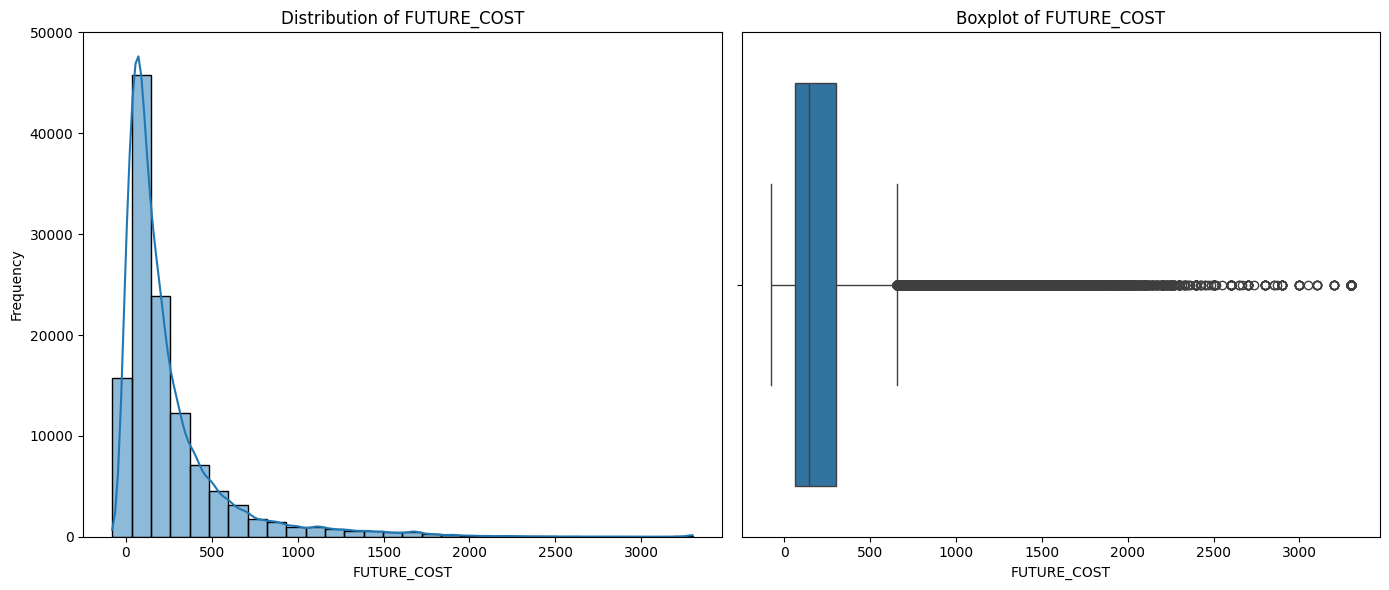

In [115]:
plot_target_variable(MDL_CLM_TRAINING_DF,'FUTURE_COST')

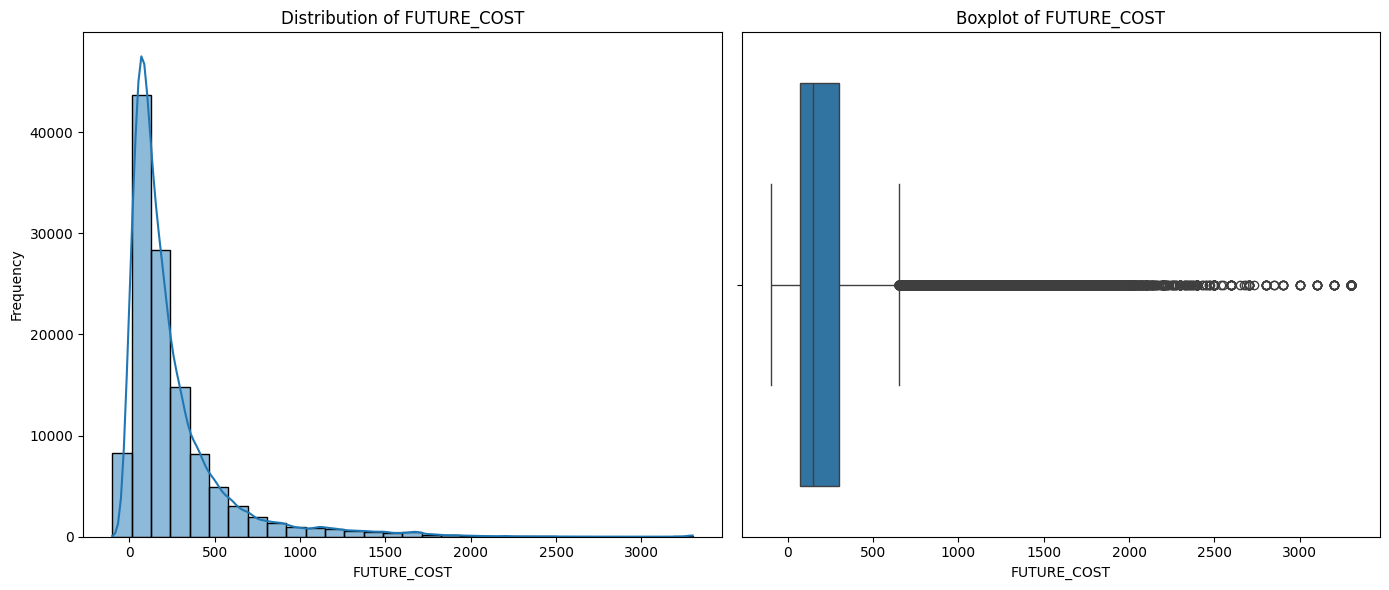

In [116]:
plot_target_variable(MDL_CLM_OOT_DF,'FUTURE_COST')

### EDA

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler


class EDA:
    def __init__(self, df, target):
        self.df = df
        self.target = target

    def summary_statistics(self):
        """Summary statistics for numerical and categorical features."""
        print("Summary Statistics for Numerical Features:")
        print(self.df.describe())  # Summary statistics for numeric columns
        
#         print("\nSummary for Categorical Features:")
#         print(self.df.describe(include=['object']))  # Summary for categorical columns

    def correlation_analysis(self):
        """Correlation heatmap for numerical features with respect to the target variable."""
        corr = self.df.corr()
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title(f'Correlation Heatmap of {self.target}')
        plt.show()

    def missing_values_analysis(self):
        """Plot missing values in the DataFrame."""
        missing = self.df.isnull().sum()
        missing_percent = (missing / len(self.df)) * 100
        missing_data = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_data.index, y=missing_data['Percentage'], palette='Set2')
        plt.title('Missing Values Analysis')
        plt.xticks(rotation=90)
        plt.show()

    def outlier_analysis(self):
        """Outlier detection for the target variable using a boxplot."""
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=self.df[self.target])
        plt.title(f'Outlier Detection for {self.target}')
        plt.show()

    def plot_feature_distribution(self, features):
        """Plot the distribution of numerical features."""
        for feature in features:
            if self.df[feature].dtype in ['int64', 'float64']:
                plt.figure(figsize=(8, 6))
                sns.histplot(self.df[feature], kde=True, bins=30)
                plt.title(f'Distribution of {feature}')
                plt.show()

    def class_balance(self):
        """Class balance for classification target variable."""
        plt.figure(figsize=(8, 6))
        sns.countplot(x=self.df[self.target], palette='Set1')
        plt.title(f'Class Balance of {self.target}')
        plt.show()

    def feature_importance_analysis(self):
        """Calculate and plot feature importance using RandomForestClassifier."""
        X = self.df.drop(columns=[self.target])
        y = self.df[self.target]
        
#         self.handle_infinity_values()
        model = RandomForestRegressor()
        model.fit(X, y)
        
        feature_importances = model.feature_importances_
        features = X.columns
        importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importance_df['Feature'], y=importance_df['Importance'], palette='viridis')
        plt.title('Feature Importance Analysis')
        plt.xticks(rotation=90)
        plt.show()

    def pairwise_relationships(self, features):
        """Plot pairwise relationships between features."""
        sns.pairplot(self.df[features])
        plt.title('Pairwise Relationships between Features')
        plt.show()

    def target_vs_features(self, features):
        """Plot the target variable against each feature."""
        for feature in features:
            if self.df[feature].dtype in ['int64', 'float64']:
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=self.df[feature], y=self.df[self.target])
                plt.title(f'{feature} vs {self.target}')
                plt.show()
            else:
                plt.figure(figsize=(8, 6))
                sns.boxplot(x=self.df[feature], y=self.df[self.target])
                plt.title(f'{feature} vs {self.target}')
                plt.show()

    def time_series_analysis(self, time_column):
        """Plot the target variable over time."""
        self.df[time_column] = pd.to_datetime(self.df[time_column])
        df_grouped = self.df.groupby(time_column)[self.target].mean().reset_index()
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_grouped, x=time_column, y=self.target)
        plt.title(f'{self.target} Over Time')
        plt.show()
    
    def convert_columns_to_float(self):
        """Convert columns containing numeric values stored as strings to float."""
        # Loop through each column
        for col in self.df.columns:
            # Check if the column is of type object (i.e., potentially a string)
            if self.df[col].dtype == 'object':
                # Attempt to convert the column to float, handling errors gracefully
                try:
                    # Convert to float, errors='coerce' will turn non-convertible values into NaN
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce')
                    print(f"Column '{col}' converted to float.")
                except Exception as e:
                    print(f"Error converting column '{col}' to float: {e}")
            else:
                print(f"Column '{col}' is already numeric.")
    
    def handle_infinity_values(self):
        """Handle infinity or very large values in the dataset."""
        # Replace infinity with NaN
        self.df.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Optionally, you can fill NaN values with some default value (e.g., mean, median, or 0)
        self.df.fillna(self.df.mean(), inplace=True)
        
        print("Infinity values replaced with NaN, and NaN values filled with column mean.")
    
    def standardize_features(self):
        """Standardize the numerical features (zero mean, unit variance)."""
        numeric_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        scaler = StandardScaler()
        
        # Apply scaling only to numeric columns
        self.df[numeric_cols] = scaler.fit_transform(self.df[numeric_cols])
        
        print(f"Standardized the following columns: {', '.join(numeric_cols)}")

# Usage Example
# Assuming `df` is the DataFrame and 'target_column' is the target variable in the dataset


Column 'DESYNPUF_ID' is already numeric.
Column 'ICD9_DGNS_CD_1' is already numeric.
Column 'ICD9_DGNS_CD_2' is already numeric.
Column 'ICD9_DGNS_CD_3' is already numeric.
Column 'ICD9_DGNS_CD_4' is already numeric.
Column 'ICD9_DGNS_CD_5' is already numeric.
Column 'ICD9_DGNS_CD_6' is already numeric.
Column 'ICD9_DGNS_CD_7' is already numeric.
Column 'ICD9_DGNS_CD_8' is already numeric.
Column 'ICD9_DGNS_CD_9' is already numeric.
Column 'ICD9_DGNS_CD_10' is already numeric.
Column 'ICD9_PRCDR_CD_1' is already numeric.
Column 'ICD9_PRCDR_CD_2' is already numeric.
Column 'ICD9_PRCDR_CD_3' is already numeric.
Column 'ICD9_PRCDR_CD_4' is already numeric.
Column 'ICD9_PRCDR_CD_5' is already numeric.
Column 'ICD9_PRCDR_CD_6' is already numeric.
Column 'HCPCS_CD_1' is already numeric.
Column 'HCPCS_CD_2' is already numeric.
Column 'HCPCS_CD_3' is already numeric.
Column 'HCPCS_CD_4' is already numeric.
Column 'HCPCS_CD_5' is already numeric.
Column 'HCPCS_CD_6' is already numeric.
Column '

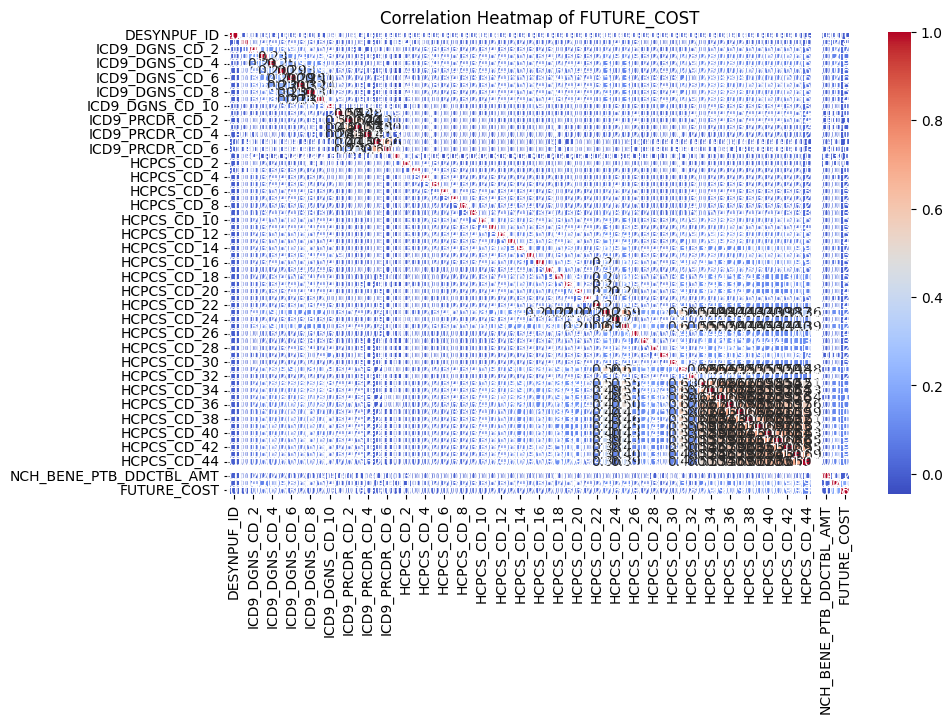

C:\Users\atul1\AppData\Local\Temp\ipykernel_19624\2504679271.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data.index, y=missing_data['Percentage'], palette='Set2')


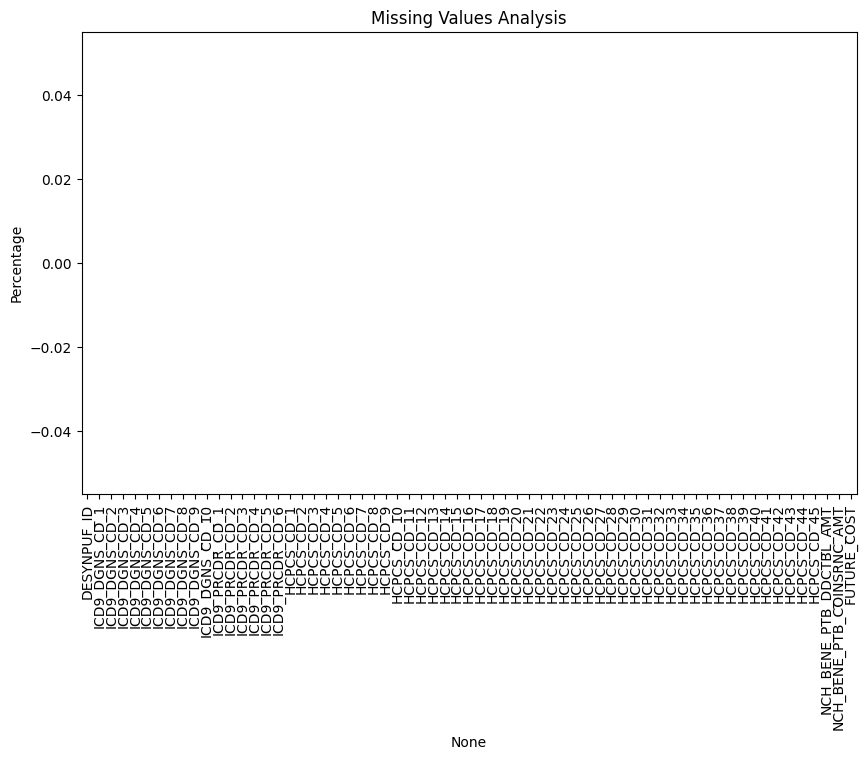

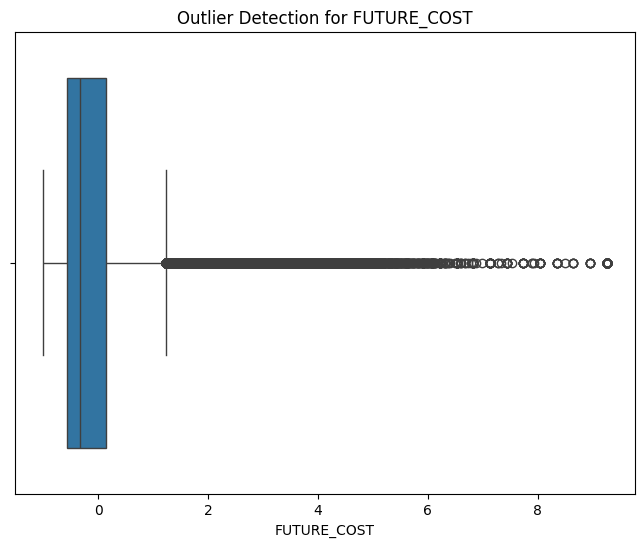

Infinity values replaced with NaN, and NaN values filled with column mean.


C:\Users\atul1\AppData\Local\Temp\ipykernel_19624\2504679271.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Feature'], y=importance_df['Importance'], palette='viridis')


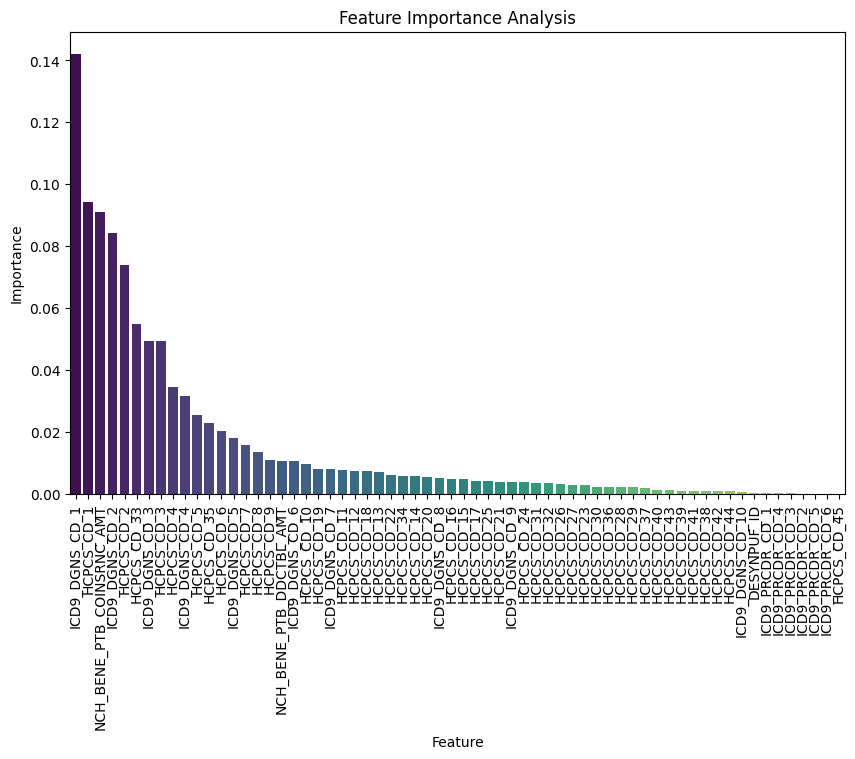

In [131]:
eda = EDA(MDL_CLM_TRAINING_DF, target='FUTURE_COST')

# Call the methods you want to analyze
eda.convert_columns_to_float()
# eda.standardize_features() 
eda.summary_statistics()
eda.correlation_analysis()
eda.missing_values_analysis()
eda.outlier_analysis()
# eda.plot_feature_distribution(features=['feature1', 'feature2', 'feature3'])
# eda.class_balance()
eda.feature_importance_analysis()
# eda.pairwise_relationships(features=['feature1', 'feature2', 'feature3'])
# eda.target_vs_features(features=['feature1', 'feature2', 'feature3'])
# eda.time_series_analysis(time_column='date_column')
